In [1]:
'''
- Dijkstra's algorithm finds least cost path on Directed Acyclic Graph (DAG). 
- A 2D grid structured DAG will be used as a maze.
- Goal is to use Dijkstra to navigate from start to finish.
- Maze starts from a random point in the border and finishes at a random point in the maze.
'''

"\n- Dijkstra's algorithm finds least cost path on Directed Acyclic Graph (DAG). \n- A 2D grid structured DAG will be used as a maze.\n- Goal is to use Dijkstra to navigate from start to finish.\n- Maze starts from a random point in the border and finishes at a random point in the maze.\n"

In [1053]:
import random
random.seed(15)
# seed 5, len 10 problem
# seed 6, len 5 (0,4)에 문제 있던 애
class Node:
    def __init__(self, coordinate, neighbors=None):
        """
        coordinate: node's coordinate in the grid

        initialize is_visited as False

        If node is start node,
        self.is_start=True, else self.is_start=None

        If node is end node,
        self.is_end=True, else self.is_end=None

        neighbors: list of neighbors / directions node can access
        Each element is a tuple of direction and random weight that ranges [0:9]
        """
        self.coordinate = coordinate
        self.is_visited = False
        # each node can have many children but only one parent node
        self.parent_direction = None
        self.is_start = False
        self.is_end = False

        if neighbors is None:
            self.neighbors = []
        else:
            self.neighbors = neighbors

    def mark_as_start_node(self):
        """
        marks is_start True if
        the node is start node
        """
        self.is_start = True

    def mark_as_end_node(self):
        """
        marks is_end True if
        the node is start node
        """
        self.is_end = True
        self.neighbors = []


# noinspection PyUnresolvedReferences
class GridGraphMaze:
    def __init__(self, length):
        """
        Makes grid and insert Node obj in grid
        Marks start and end nodes 
        Directions/neighbors are represented using four numbers:
          8
        4   6
          2
        """
        self.length = length
        # make length x length grid
        self.grid = [[0 for _ in range(length)] for _ in range(length)]

        self.q = []  # before queue, now changed to list to randomly sample nodes

        # list of visited / unvisited nodes
        self.visited_nodes_ls = []
        self.unvisited_nodes_ls = []
        
        # choose start/end points at a side of the grid
        self.start_coord, self.end_coord = self.choose_start_end_coord()

        # insert nodes with coordinate in grid
        for i in range(length):
            for j in range(length):
                self.grid[i][j] = Node((i, j))
                self.unvisited_nodes_ls.append(self.grid[i][j])

                # mark start & end in Node
                if self.grid[i][j].coordinate[0] == self.start_coord[0] and \
                        self.grid[i][j].coordinate[1] == self.start_coord[1]:
                    self.grid[i][j].mark_as_start_node()

                if self.grid[i][j].coordinate[0] == self.end_coord[0] and \
                        self.grid[i][j].coordinate[1] == \
                        self.end_coord[1]:
                    self.grid[i][j].mark_as_end_node()

    @staticmethod
    def rand_weight():
        return random.choices([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])[0]

    def choose_start_end_coord(self):
        start, end = (0, 0), (0, 0)
        start_end_dist = 0
        min_dist = int(self.length/2)
        while start_end_dist < min_dist:
            start, end = (
                random.choice([(0, random.choice(range(self.length))),
                               (self.length - 1, random.choice(range(self.length))),
                               (random.choice(range(self.length)), 0),
                               (random.choice(range(self.length)), self.length - 1)]),
                (random.choice(range(self.length)), random.choice(range(self.length)))
            )
            x1 = start[0]
            x2 = start[1]
            y1 = end[0]
            y2 = end[1]
            start_end_dist = int( (abs(x1-x2)**2+abs(y1-y2)**2)**1/2 )
        return start, end

    def find_accessible_directions_of_node(self, node):
        i, j = node.coordinate
        # adjacent node directions
        if i == 0 and j == 0:
            accessible_directions = [2, 6]
        elif i == 0 and j == self.length - 1:
            accessible_directions = [2, 4]
        elif i == self.length - 1 and j == 0:
            accessible_directions = [6, 8]
        elif i == self.length - 1 and j == self.length - 1:
            accessible_directions = [4, 8]
        elif i == 0:
            accessible_directions = [2, 4, 6]
        elif j == 0:
            accessible_directions = [2, 6, 8]
        elif i == self.length - 1:
            accessible_directions = [4, 6, 8]
        elif j == self.length - 1:
            accessible_directions = [2, 4, 8]
        else:
            accessible_directions = [2, 4, 6, 8]
        return accessible_directions

    def choose_random_number_of_neighbors(self, node):
        """
        Checks if accessible nodes(unvisited) are visited or not
        and adds only accessible nodes to node's neighbors randomly
        1. end 면 fin 넣어줌
        2. deadend 면 deadend 넣어줌
        """
        if node.is_end:
            node.neighbors = ['fin']
            return

        # if node is deadend, don't add any directions (but it needs parent)
        if not node.is_start and self.is_deadend(node):
            node.neighbors = ['deadend']
            return

        accessible_directions = self.find_accessible_directions_of_node(node)
        
        # if node is NOT starting node, remove direction toward curr node's parent in accessible_directions!
        # (shouldn't be able to go back toward parent)
        if not node.is_start:
            p_dir = node.parent_direction
            if p_dir == 2:
                accessible_directions.remove(2)
            elif p_dir == 4:
                accessible_directions.remove(4)
            elif p_dir == 6:
                accessible_directions.remove(6)
            else:
                accessible_directions.remove(8)
            
        #  delete visited nodes from directions to avoid sampling them
        i, j = node.coordinate
        for direction in accessible_directions[:]:
            if direction==2:
                if self.grid[i+1][j].is_visited:
                    accessible_directions.remove(2)
            elif direction==4:
                if self.grid[i][j-1].is_visited:
                    accessible_directions.remove(4)
            elif direction==6:
                if self.grid[i][j+1].is_visited:
                    accessible_directions.remove(6)
            else:
                if self.grid[i-1][j].is_visited:
                    accessible_directions.remove(8)
                    
        # now choose random number of directions
        if len(accessible_directions)==3:
            n_dir = random.choices([1,2,3], weights=[0.7, 0.25, 0.05])[0]
        elif len(accessible_directions)==2:
            n_dir = random.choices([1,2], weights=[0.85, 0.15])[0]
        else:
            n_dir = 1
            
        sampled_directions = random.sample(accessible_directions, n_dir)
        
        # mark neighbors as visited ahead of time (here) to prevent collision
        for direction in sampled_directions:
            if direction == 2:
                if not self.grid[i + 1][j].is_visited:
                    node.neighbors.append((2, self.rand_weight()))
                    self.grid[i + 1][j].is_visited = True
                    self.visited_nodes_ls.append(self.grid[i + 1][j])
                    self.unvisited_nodes_ls.remove(self.grid[i + 1][j])
                    self.q.append(self.grid[i + 1][j])
            elif direction == 4:
                if not self.grid[i][j - 1].is_visited:
                    node.neighbors.append((4, self.rand_weight()))
                    self.grid[i][j - 1].is_visited = True
                    self.visited_nodes_ls.append(self.grid[i][j - 1])
                    self.unvisited_nodes_ls.remove(self.grid[i][j - 1])
                    self.q.append(self.grid[i][j - 1])
            elif direction == 6:
                if not self.grid[i][j + 1].is_visited:
                    node.neighbors.append((6, self.rand_weight()))
                    self.grid[i][j + 1].is_visited = True
                    self.visited_nodes_ls.append(self.grid[i][j + 1])
                    self.unvisited_nodes_ls.remove(self.grid[i][j + 1])
                    self.q.append(self.grid[i][j + 1])
            else:
                if not self.grid[i - 1][j].is_visited:
                    node.neighbors.append((8, self.rand_weight()))
                    self.grid[i - 1][j].is_visited = True
                    self.visited_nodes_ls.append(self.grid[i - 1][j])
                    self.unvisited_nodes_ls.remove(self.grid[i - 1][j])
                    self.q.append(self.grid[i - 1][j])

    def set_node_as_parent_of_neighbors(self, node):
        # no need to set end node or deadend node as parent of other nodes
        if node.is_end:
            return
        elif not node.is_start and self.is_deadend(node):
            return

        i, j = node.coordinate
        for neigh in node.neighbors:
            dir = neigh[0]

            if dir == 2:
                self.grid[i + 1][j].parent_direction = 8
            elif dir == 4:
                self.grid[i][j - 1].parent_direction = 6
            elif dir == 6:
                self.grid[i][j + 1].parent_direction = 4
            elif dir == 8:
                self.grid[i - 1][j].parent_direction = 2

    def is_deadend(self, node):
        """
        checks if node is a deadend:
        = all adjacent nodes are visited
        """
        acc_dir = self.find_accessible_directions_of_node(node)
        acc_dir.remove(node.parent_direction)  # exclude dir current node came from (parent direction)

        n_directions = len(acc_dir)
        n_visited_neigh_but_not_in_my_neigh = 0
        i, j = node.coordinate

        my_neigh = [neigh[0] for neigh in node.neighbors]

        for direction in acc_dir:
            if direction not in my_neigh:
                if direction == 2:
                    if self.grid[i + 1][j].is_visited:
                        n_visited_neigh_but_not_in_my_neigh += 1
                elif direction == 4:
                    if self.grid[i][j - 1].is_visited:
                        n_visited_neigh_but_not_in_my_neigh += 1
                elif direction == 6:
                    if self.grid[i][j + 1].is_visited:
                        n_visited_neigh_but_not_in_my_neigh += 1
                else:
                    if self.grid[i - 1][j].is_visited:
                        n_visited_neigh_but_not_in_my_neigh += 1

        if n_visited_neigh_but_not_in_my_neigh == n_directions:
            return True
        else:
            return False

    def find_unvisited_nodes_from_visited(self, node):
        """
        given a node, finds unvisited(previously unselected) node,
        add direction & weight of newly added unvisited node in node,
        add parent_direction to newly added unvisited node

        returns True if node with unvisited direction is added to q else False
        """
        # if encounter a node that has only been added as neighbor, and no neighbor added yet
        print('node.coordinate',node.coordinate)
        if len(node.neighbors)==0:
            return False
        
        accessible_directions = self.find_accessible_directions_of_node(node)
        
        if not node.is_start:
            accessible_directions.remove(node.parent_direction)
        
        i, j = node.coordinate
        for direction in accessible_directions:
            if direction == 2:
                if not self.grid[i + 1][j].is_visited:
                    node.neighbors.append((2, self.rand_weight()))
                    self.grid[i + 1][j].is_visited = True
                    self.grid[i + 1][j].parent_direction = 8
                    self.q.append(self.grid[i + 1][j])
                    self.unvisited_nodes_ls.remove(self.grid[i + 1][j])
                    return  True
            elif direction == 4:
                if not self.grid[i][j - 1].is_visited:
                    node.neighbors.append((4, self.rand_weight()))
                    self.grid[i][j - 1].is_visited = True
                    self.grid[i][j - 1].parent_direction = 6
                    self.q.append(self.grid[i][j - 1])
                    self.unvisited_nodes_ls.remove(self.grid[i][j - 1])
                    return True
            elif direction == 6:
                if not self.grid[i][j + 1].is_visited:
                    node.neighbors.append((6, self.rand_weight()))
                    self.grid[i][j + 1].is_visited = True
                    self.grid[i][j + 1].parent_direction = 4
                    self.q.append(self.grid[i][j + 1])
                    self.unvisited_nodes_ls.remove(self.grid[i][j + 1])
                    return True
            else:
                if not self.grid[i - 1][j].is_visited:
                    node.neighbors.append((8, self.rand_weight()))
                    self.grid[i - 1][j].is_visited = True
                    self.grid[i - 1][j].parent_direction = 2
                    self.q.append(self.grid[i - 1][j])
                    self.unvisited_nodes_ls.remove(self.grid[i - 1][j])
                    return True
            
        return False
    
    def there_is_still_unvisited_nodes(self, node):
        """
        two cases: 
        1. unvisited node has unvisited neighbors 
        2. unvisited node has no unvisited neighbors  
        :param node: an unvisited node from unvisited_nodes_ls
        :return: unvisited node if case 1. else False
        """
        accessible_directions = self.find_accessible_directions_of_node(node)
        
        # check if there are unvisited neighbors
        visited_directions = []
        i, j = node.coordinate
        for direction in accessible_directions[:]:
            if direction==2:
                if self.grid[i+1][j].is_visited:
                    accessible_directions.remove(2)
                    visited_directions.append(2)
            elif direction==4:
                if self.grid[i][j-1].is_visited:
                    accessible_directions.remove(4)
                    visited_directions.append(4)
            elif direction==6:
                if self.grid[i][j+1].is_visited:
                    accessible_directions.remove(6)
                    visited_directions.append(6)
            else:
                if self.grid[i-1][j].is_visited:
                    accessible_directions.remove(8)
                    visited_directions.append(8)
        
        if len(accessible_directions) == 0: # there are no unvisited neighbors
            if node.parent_direction is None: # for case when only one isolated node was not visited
                node.parent_direction = random.sample(visited_directions,1)[0]
                if node.parent_direction == 2:
                    self.grid[i+1][j].neighbors.append((8, self.rand_weight()))
                elif node.parent_direction == 4:
                    self.grid[i][j-1].neighbors.append((6, self.rand_weight()))
                elif node.parent_direction == 6:
                    self.grid[i][j+1].neighbors.append((4, self.rand_weight()))
                else:
                    self.grid[i-1][j].neighbors.append((2, self.rand_weight()))
                
            node.neighbors = ['deadend']
            return False
        
        else: # there are unvisited neighbor
            # parent dir None if first of the chain/series of unvisited nodes
            if not node.is_start:
                if node.parent_direction is None: 
                    node.parent_direction = random.sample(visited_directions,1)[0]
            
            unvisited_neigh_dir = random.sample(accessible_directions,1)[0]
            
            i, j = node.coordinate
            if unvisited_neigh_dir == 2:
                node.neighbors.append((2, self.rand_weight()))
                self.grid[i+1][j].parent_direction = 8
                return self.grid[i+1][j]
            elif unvisited_neigh_dir == 4:
                node.neighbors.append((4, self.rand_weight()))
                self.grid[i][j-1].parent_direction = 6
                return self.grid[i][j-1]
            elif unvisited_neigh_dir == 6:
                node.neighbors.append((6, self.rand_weight()))
                self.grid[i][j+1].parent_direction = 4
                return self.grid[i][j+1]
            else:
                node.neighbors.append((8, self.rand_weight()))
                self.grid[i-1][j].parent_direction = 2
                return self.grid[i-1][j]
            
    def make_maze(self, start_node):
        self.q.append(start_node)
        start_node.is_visited = True
        self.visited_nodes_ls.append(start_node)
        self.unvisited_nodes_ls.remove(start_node)
        while len(self.q) > 0:
            node = random.sample(self.q, 1)[0]
            self.q.remove(node)  # need to sample deadend & end in order to label them in node's neighbors
            print(node.coordinate)

            # making path step
            # choose random number of unvisited neighbors
            self.choose_random_number_of_neighbors(node)
            # make node a parent of the neighbors of node
            self.set_node_as_parent_of_neighbors(node)
            
            # if meet end node but there's still unvisited nodes in grid,
            # choose a new node from visited nodes to find node with unchosen accessible neighbor
            if node.neighbors[0] == 'fin' or node.neighbors[0] == 'deadend':
                if len(self.unvisited_nodes_ls) != 0:
                    found = False
                    while not found:
                        visited_node = random.sample(self.visited_nodes_ls,1)[0]
                        # skip searching end node from visited_nodes_ls (don't want to search new route from end node)
                        if visited_node.is_end:
                            continue
                        found = self.find_unvisited_nodes_from_visited(visited_node)
                    
        # if there are still unvisited nodes
        # if len(self.unvisited_nodes_ls) != 0:
        #     node = random.sample(self.unvisited_nodes_ls,1)[0]
        #     
        #     while len(self.unvisited_nodes_ls) != 0:
        #         while node:
        #             node.is_visited = True
        #             self.visited_nodes_ls.append(node)
        #             self.unvisited_nodes_ls.remove(node)
        #             node = self.there_is_still_unvisited_nodes(node)
        #         
        #         if len(self.unvisited_nodes_ls) == 0:
        #             break
        #         else:
        #             node = random.sample(self.unvisited_nodes_ls,1)[0]
                                

In [1054]:
grid_length=6
grid_graph = GridGraphMaze(length=grid_length)

#check direction/number of neighbors
print('start:',grid_graph.start_coord)
print('end:',grid_graph.end_coord)
print()

st_i,st_j = grid_graph.start_coord
st_node = grid_graph.grid[st_i][st_j]

grid_graph.make_maze(st_node) 

# 100 by 100 grid => 0.5 second
# 300 by 300 grid => 44 seconds



start: (5, 0)
end: (1, 0)

(5, 0)
(4, 0)
(4, 1)
(3, 1)
(3, 2)
(3, 3)
(2, 3)
(3, 4)
(2, 2)
(2, 4)
(2, 5)
(3, 5)
(1, 4)
(4, 5)
(0, 4)
(4, 4)
(4, 3)
(1, 2)
(1, 3)
0
node.coordinate (4, 0)
(3, 0)
(2, 0)
(1, 1)
(2, 1)
0
node.coordinate (3, 5)
1
node.coordinate (1, 4)
(1, 0)
0
node.coordinate (5, 3)
1
node.coordinate (4, 5)
(0, 3)
(0, 2)
(5, 5)
(5, 3)
(5, 2)
(5, 4)
0
node.coordinate (0, 4)
(0, 5)
0
node.coordinate (1, 4)
1
node.coordinate (2, 0)
2
node.coordinate (3, 4)
3
node.coordinate (1, 2)
4
node.coordinate (4, 2)
5
node.coordinate (4, 0)
6
node.coordinate (5, 4)
7
node.coordinate (3, 3)
8
node.coordinate (1, 1)
9
node.coordinate (5, 4)
10
node.coordinate (4, 4)
11
11
node.coordinate (5, 1)
12
node.coordinate (3, 1)
13
node.coordinate (0, 1)
14
14
node.coordinate (4, 3)
15
node.coordinate (2, 5)
16
node.coordinate (1, 2)
17
node.coordinate (5, 4)
18
node.coordinate (5, 2)
19
node.coordinate (5, 4)
20
node.coordinate (3, 2)
21
node.coordinate (1, 2)
22
node.coordinate (3, 1)
23
node.coor

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



node.coordinate (1, 3)
249988
node.coordinate (0, 2)
249989
node.coordinate (2, 4)
249990
node.coordinate (4, 0)
249991
node.coordinate (5, 4)
249992
node.coordinate (5, 3)
249993
node.coordinate (2, 0)
249994
node.coordinate (2, 1)
249995
node.coordinate (3, 3)
249996
node.coordinate (5, 4)
249997
node.coordinate (3, 2)
249998
249998
node.coordinate (2, 5)
249999
node.coordinate (3, 2)
250000
250000
node.coordinate (1, 2)
250001
node.coordinate (1, 2)
250002
node.coordinate (1, 3)
250003
node.coordinate (1, 4)
250004
node.coordinate (2, 2)
250005
node.coordinate (5, 1)
250006
node.coordinate (2, 4)
250007
node.coordinate (0, 1)
250008
node.coordinate (4, 4)
250009
node.coordinate (2, 1)
250010
node.coordinate (2, 3)
250011
node.coordinate (1, 2)
250012
node.coordinate (4, 2)
250013
node.coordinate (3, 4)
250014
node.coordinate (2, 1)
250015
node.coordinate (2, 1)
250016
node.coordinate (5, 4)
250017
node.coordinate (2, 1)
250018
node.coordinate (3, 1)
250019
node.coordinate (4, 5)
250

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [1055]:
for i in grid_graph.grid:
    for j in i:
        print(''.join([str(x[0]) for x in j.neighbors]), end='\t')
    print()
print()

		4	4	46	d	
f	2	46	d	86		
8	d	8	4	86	2	
8	6	6	86	8	2	
68	8		2	4	42	
8		84	4	d	4	


In [933]:
for i in grid_graph.grid:
    for j in i:
        print(j.parent_direction, end='\t')
    print()
print()

for i in grid_graph.grid:
    for j in i:
        print(j.is_visited, end=' ')
    print()
print()

None	None	None	None	2	4	
None	None	None	None	6	2	
None	None	None	None	2	4	
None	2	4	4	6	2	
2	4	8	8	4	4	
None	6	8	6	8	None	

False False False False True True 
False True False False True True 
False False False False True True 
False True True True True True 
True True True True True True 
True True True True True False 


In [825]:
'''
Todos:
-mark end coord with color
-once maze is made, draw outline of maze based on direction of each cell
'''

'\nTodos:\n-mark end coord with color\n-once maze is made, draw outline of maze based on direction of each cell\n'

In [873]:
import numpy as np

[[255, 255, 255, 255, 255, 255, 255, 255],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [255, 255, 255, 255, 255, 255, 255, 255]]

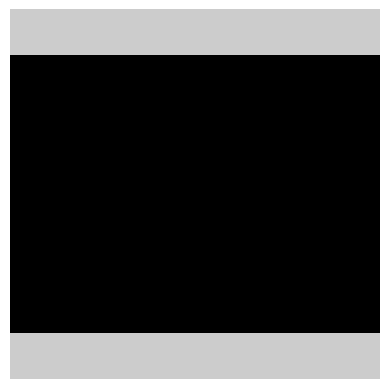

In [891]:
import matplotlib.pyplot as plt

# Create a sample 2D array of values
data = [[.8]*8 if i==0 or i==7 else [0]*8 for i in range(8)]

# Create a heatmap plot
plt.imshow(data, cmap='gray',vmin=0, vmax=1)
# plt.colorbar()  # Add a colorbar to the plot
plt.axis('off')

# Display the plot
plt.show()

In [896]:
for i in range(0,6):
    for j in range(i*8,(i+1)*8):
        print(j)
    print()

0
1
2
3
4
5
6
7

8
9
10
11
12
13
14
15

16
17
18
19
20
21
22
23

24
25
26
27
28
29
30
31

32
33
34
35
36
37
38
39

40
41
42
43
44
45
46
47
